In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


In [2]:
#Mouting the google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [8]:
#Unzipping the zipfile
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/lfw.zip', 'r') as zip_ref:
    zip_ref.extractall('')

In [9]:
path = '/content/lfw'

In [10]:
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [11]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([256, 256, 3])


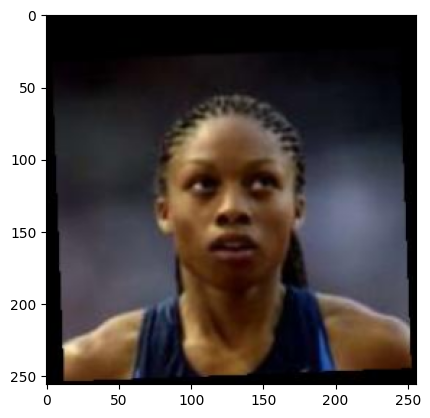

In [12]:
#Plotting an sample image

for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

Sample data dimension =  torch.Size([3, 256, 256])


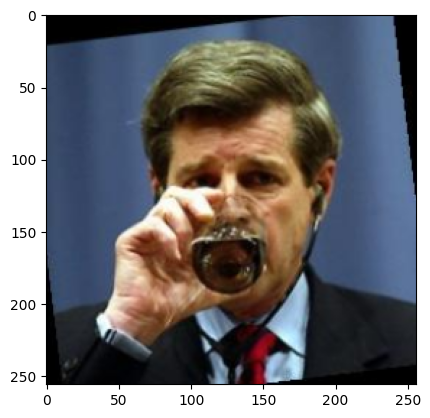

In [13]:
for x, y  in dataloader:
  sampleData = x[0];

  print("Sample data dimension = ", sampleData.shape)

  # Plotting the sample image
  plt.imshow(sampleData.permute(1, 2, 0))
  plt.show()

  break

****Summary of the dimension****

The sample image's dimension shows in the form (C, W, H) which means the C stands for color channels, W for width and H for heigth.



*   If C is "1", it is grayscale image.
*   If C is "3", it is color image.
*   Color channel includes RGB.







# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#Creating AutoEncoder
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Layers for Encoder which includes Conv2d and BatchNorm2d
        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(32)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(64)
        self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.encoder_bn3 = nn.BatchNorm2d(128)

        # Layers for Decoder which includes ConvTranspose2d and BatchNorm2d
        self.decoder_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_bn1 = nn.BatchNorm2d(64)
        self.decoder_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_bn2 = nn.BatchNorm2d(32)
        self.decoder_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_bn3 = nn.BatchNorm2d(3)

    #Encoder function
    def encoder(self, x):
        x = F.relu(self.encoder_bn1(self.encoder_conv1(x)))
        x = F.relu(self.encoder_bn2(self.encoder_conv2(x)))
        x = F.relu(self.encoder_bn3(self.encoder_conv3(x)))
        return x


    #Decoder Function
    def decoder(self, x):
        x = F.relu(self.decoder_bn1(self.decoder_conv1(x)))
        x = F.relu(self.decoder_bn2(self.decoder_conv2(x)))
        x = torch.sigmoid(self.decoder_bn3(self.decoder_conv3(x)))
        return x


    #Forward Function
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [16]:
#Creating instance of the AutoEncoder Model
autoencoder = AE()

for x, y in dataloader:
    sample_image = x[0]  # Take the first image from the batch as a sample
    break

# Add a batch dimension to the sample image
sample_image = sample_image.unsqueeze(0)

# Pass the sample image through the autoencoder
encoded_output = autoencoder.encoder(sample_image)
decoded_output = autoencoder.decoder(encoded_output)

# Print the shapes of encoder and decoder outputs
print(f"Shape of Encoder Output: {encoded_output.shape}")
print(f"Shape of Decoder Output: {decoded_output.shape}")


Shape of Encoder Output: torch.Size([1, 128, 32, 32])
Shape of Decoder Output: torch.Size([1, 3, 256, 256])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [18]:
# Print total number of parameters
total_params = sum(p.numel() for p in autoencoder.parameters())
print(f"Total Number of Parameters: {total_params}")

# Loss function
criterion = nn.MSELoss()

# Optimizer
learning_rate = 0.001  # Adjust as needed
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

Total Number of Parameters: 187017


 ***Loss Function***

 **MSE** is a suitable and widely used choice for image autoencoders due to its alignment with the reconstruction objective, compatibility with continuous pixel values, differentiability, and computational efficiency.

 It has following characteristics:-  

*   Reconstruction Objective
*   Continuous Pixel Values
*   Differentiability
*   Mathematical Simplicity





##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [19]:
import torch
import torch.nn as nn


num_epochs = 5  # You can adjust this value

for epoch in range(num_epochs):
    total_loss = 0.0

    # Training
    for inputs, _ in dataloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder.forward(inputs)
        # print(f"Input Shape: {inputs.shape}, Output Shape: {outputs.shape}")

        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print average loss for the epoch
    average_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

# # Training complete
# print('Finished Training')


Epoch [1/5], Loss: 0.0157
Epoch [2/5], Loss: 0.0043
Epoch [3/5], Loss: 0.0022
Epoch [4/5], Loss: 0.0013
Epoch [5/5], Loss: 0.0011


**The following troubleshooting actions may be taken into consideration if the loss is not decreasing:**

***Modification of Learning Rate:*** Lower the optimizer's learning rate. The optimizer may overshoot the minimum if the learning rate is excessive.

***Model Complexity:*** An overly complicated model may overfit the training set. Think about making the model architecture simpler.

***Data Problems:*** Examine your training data's quality and preparation. Make sure it is anomaly-free and normalized.

Examine  gradients for gradient explosion or NaN values (see below). Adjust slopes as necessary.



##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

Original Image:


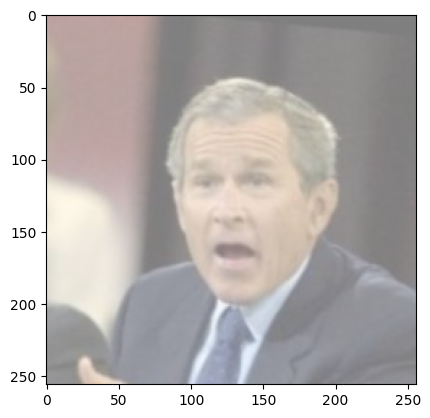

Reconstructed Image:


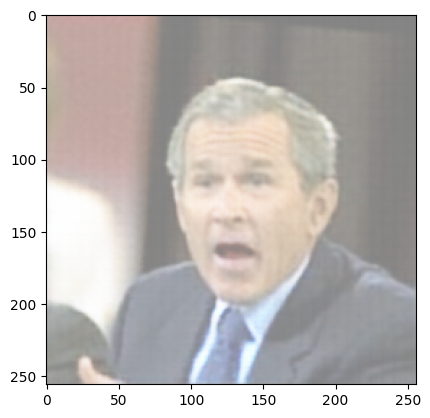

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision


# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a random batch of images from the dataset
dataiter = iter(dataloader)
images, _ = next(dataiter)
random_image = images[0].unsqueeze(0)


# Pass the random image through the autoencoder
reconstructed_image = autoencoder(random_image)

# Display the original and reconstructed images
print("Original Image:")
imshow(torchvision.utils.make_grid(random_image))

print("Reconstructed Image:")
imshow(torchvision.utils.make_grid(reconstructed_image.detach()))

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

Original Image:


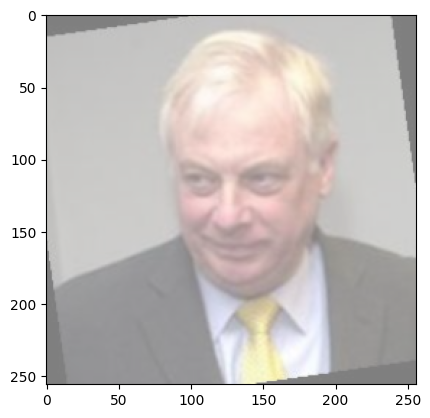

Reconstructed Image:


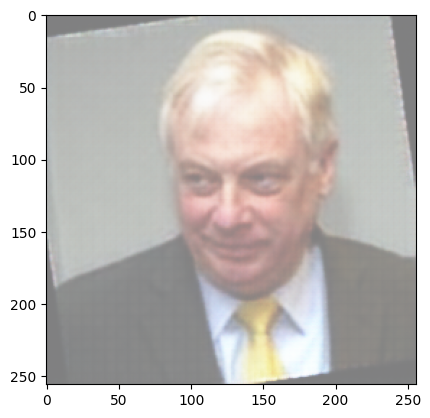

Perturbed Reconstructed Image:


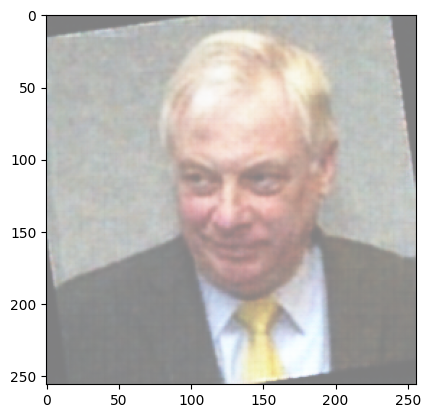

In [27]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

path = 'lfw'
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform), batch_size=32, shuffle=True)

def add_noise(latent_representation, noise_factor=0.2):
    noise = torch.randn_like(latent_representation) * noise_factor
    perturbed_latent = latent_representation + noise
    return perturbed_latent

# Get a random image from the dataset
dataiterator = iter(dataloader)
images, _ = dataiterator.__next__()
random_image = images[0].unsqueeze(0)

# Pass the random image through the autoencoder
encoded_output = autoencoder.encoder(random_image)
decoded_output = autoencoder.decoder(encoded_output)

# Display the original and reconstructed images
print("Original Image:")
imshow(torchvision.utils.make_grid(random_image))

print("Reconstructed Image:")
imshow(torchvision.utils.make_grid(decoded_output))

# Add noise to the latent representation and decode again
perturbed_latent = add_noise(encoded_output)
perturbed_decoded_output = autoencoder.decoder(perturbed_latent)

# Display the perturbed reconstructed image
print("Perturbed Reconstructed Image:")
imshow(torchvision.utils.make_grid(perturbed_decoded_output))


>Adding noise to the latent representation of the input image and then decoding it is a popular method called "denoising autoencoder." It aids in the model's learning of a more reliable and comprehensive representation of the incoming data. In this instance, the latent space is somewhat perturbed by a normally distributed noise, and the model is anticipated to reconstruct the original image in spite of the noise.


>By adding noise (perturbed_latent), this adjustment perturbs the latent representation. The perturbed-decoded image is then obtained by decoding the perturbed latent representation. The extra noise is intended to be minimal, and it's interesting to see how it affects the final decoded image.



> By introducing noise into the latent representation, the reconstruction becomes smoother and more resilient, assisting the model in learning features that are less susceptible to minute changes in the input. It serves as a regularization method and enhances the autoencoder's capacity for generalization.




